Algorithm of SIR model
1. An array is used to represent the population in a grid lattice where 0,1 and 2 represent the Suscpetible , infected and recovered rescpetively.
2. beta and gamma are the propensity value for a single cell to cause a transmission ( infection or recovery).
In local transmission following are the steps considred
-Getting cartisian pair value of cell with value '1'.
-Getting the set of neighbours to the above list who has the value '0'. Set is considered to avoid repeatation. 
-assiging value 1 or 0 to variable 'rand1' with a probablity of beta propensity for each iteration wrt values in set(susceptible neighbours) and adding this varaible 'rand1' to the cell.Thus the randomness of transmission is wrt to the propensity value.
-same is done for the global transmission. Number of itteriation for global tranmssion is with rescpect to the number of infected cells.
3. Each infected cell is located first. Propensity value beta is used as probabilty of infecting the respective neighbouring cell or another global person.
4. Infected person are changed to recovery with the propensity value gamma with time. 
5. p value denotes the probability of local transmission. Probablity of Global transmission is calculated as (1-p).


In [1]:

#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import random as rn
import time
from openpyxl import Workbook
import os
%matplotlib inline


In [2]:
#Global Variables used in the simulation
#S,I,R are the counts of Susceptible , Infected and Recovered
#SI_pair is the neighbouring Susceptible and Infected which results in the local transmission of Disease
S=[]
I=[]
R=[]
t=[0]
V=[]
SI_pair=[0]
local_transmission_no=0
global_transmission_no=0
animation=0
matrices=[]
S_df=pd.DataFrame()
I_df=pd.DataFrame()
R_df=pd.DataFrame()
SI_pair_df=pd.DataFrame()
V_df=pd.DataFrame()
I_df_updated=pd.DataFrame()
Sim_statistics=pd.DataFrame()
local_infection_ratio=pd.DataFrame()
local_infection_ratio_sim=[]
peak=[]
peak_day=[]
Reproductive_No=0
beta = 0
gamma = 0
day_25=[]
day_50=[]
day_75=[]
beta_list=[]
P_values=[]
Sim_graph_flag1=0 # Assign flag value 0 if Simulation Graphs are Needed else 1 to skip 
vaccinated_nums=0
vacc_flag=0


In [3]:
#Declaring the variables as global variable



#Defining the functions

In [4]:
#getting the status count of population at a time step
def pop_stat(sus,inf,rec,vac,mtx):
    sus.append(mtx[np.where(mtx==0)].size)
    inf.append(mtx[np.where(mtx==1)].size)
    rec.append(mtx[np.where(mtx==2)].size)
    vac.append(vac[-1]+count)

In [5]:
#Acquires the location of the neighbouring suscpetible to the infected in a time step. Gives the list of cartesian pair of the Suscptibles.
#Neighbours are considered in the vertical and horizontal directions. Diagonals are avoided.
def SI_neighbour(mtx):
    index_x=[]
    index_y=[]
    index_x,index_y, =np.where(mtx==1)
    neigh_loc=set()
    for (i,j) in zip(index_x,index_y):
        #print(i,j)
        if i+1 <grid_size:
            if mtx[[i+1],[j]] == 0:
                neigh_loc.add(tuple(([i+1,j])))
        if i-1 > -1:
            if mtx[[i-1],[j]] == 0:
                neigh_loc.add(tuple(([i-1,j])))
        if j+1 <grid_size:
            if mtx[[i],[j+1]] == 0:
                neigh_loc.add(tuple(([i,j+1])))
        if j-1 >-1:
            if mtx[[i],[j-1]] == 0:
                neigh_loc.add(tuple(([i,j-1])))            
    return neigh_loc

In [6]:
#infected people are changed to recovred with the probability of the gamma value.
def recovering(mtx,gamma):
    recover_index_x,recover_index_y,= np.where(mtx==1)
    for (i,j) in zip (recover_index_x,recover_index_y):
        rand1=rn.choices([1,0],weights= [gamma,1-gamma],k=1)
        mtx[i,j]=mtx[i,j]+rand1

In [7]:
#infecting the neighbouring susceptible cells with a probablity of beta
#1 infected person has possibilty to infect another one susceptible in a time step.
#  A susceptible is chosen at random from the respective suscptible list
def local_infection(mtx,beta):
    SI_locs= SI_neighbour(mtx)
    for i in range (I[-1]):
        randneigh=[]
        if len(SI_locs) == 0:
            continue
        randneigh=rn.choices(tuple(SI_locs))
        rand1=rn.choices([1,0],weights= [beta,1-beta],k=1)
        if mtx[randneigh[0][0],randneigh[0][1]]==0:
            mtx[randneigh[0][0],randneigh[0][1]]=mtx[randneigh[0][0],randneigh[0][1]]+rand1    

In [8]:
#Suceptibles are infected in global level
#Number of global suscptible considered in a time step is same as the number of SI pair so that a tally is kept between the local and global.
#1 infected person has possibilty to infect another one susceptible in a time step.
#  A susceptible is chosen at random from the respective suscptible list
def global_infection(mtx,beta):
    global_pop=set()
    index_x,index_y, =np.where(mtx==0) 
    for (i,j) in zip(index_x,index_y):
        global_pop.add(tuple(list([i,j])))
    
    for i in range (len(global_pop)):
        if len(global_pop) == 0:
            continue
        randneigh=[]
        randneigh=rn.choices(tuple(global_pop))
        rand1=rn.choices([1,0],weights=[beta,1-beta],k=1)
        if mtx[randneigh[0][0],randneigh[0][1]]==0:
            mtx[randneigh[0][0],randneigh[0][1]]=mtx[randneigh[0][0],randneigh[0][1]]+rand1

In [9]:
#Vaccination of SIR model
#Both suceptible and infected is subjected to vaccination. 
#In a time step a Certain number of people (vacc_per_day)is subjected to dose. 
#This dose also given a percentage of effectiveness (mu)

def vaccination(mtx,number):
    global count
    count=0
    unvaccinated_loc=[]
    rand1=0
    vaccination_index_x,vaccination_index_y,= np.where((mtx == 1) | (mtx==0))
    unvaccinated_loc=list(zip(vaccination_index_x,vaccination_index_y))
    for i in range(number):    
        if len(unvaccinated_loc) == 0:
            break
        randunvaccinated=[]
        # print(unvaccinated_loc)
        randunvaccinated=rn.choices(unvaccinated_loc)
        rand1=rn.choices([1,0],weights= [mu,1-mu],k=1)
        if rand1[0]==1:
            mtx [randunvaccinated[0][0],randunvaccinated[0][1]]=2
            count=count+1   
    

In [10]:
#Graph ploting funciton
#Median is used to represent the simulation in general.
#The IQR for infected is plotted as box

def graph_plot_SIR(s,i,r,si,v):
    fig, (axs1,axs2) = plt.subplots(1,2,figsize=(20,10))
    ts=list(range(1,len(s)+1))
    ti=list(range(1,len(i)+1))
    tr=list(range(1,len(r)+1))
    tsi=list(range(1,len(si)+1))
    tv=list(range(1,len(v)+1))
    axs1.plot(ts,s,label = 'Susecptible')
    axs1.plot(ti,i,label = 'Infected')
    axs1.plot(tr,r,label = 'Recovered')
    # axs12=axs1.twinx()
    # axs12.plot(tv,v,label = 'Vaccinated',color='red')
    # axs12.legend(loc=1)
    if vacc_flag==0:
        axs1.plot(tv,v,label = 'Vaccinated',color='red')
    axs1.plot([],[],' ',label ='Last Recovered Day:%.0f'%req_ind[0])
    axs1.plot([],[],' ',label ='No of Vaccinated:%.0f'%((V_df['V_Mean'].tail(1))))
    axs2.plot(tsi,si,label = 'SI Pair')
    I_df_updated.T.boxplot(ax=axs1,grid=False,showfliers=False,whis=0,color='orange',patch_artist=True,boxprops={'alpha':0.5,'facecolor':'orange'})
    axs1.legend(loc=1)
    axs1.set_title('SIR p=%.1f $R_{o}$:%0.2f'%(p,Reproductive_No) )
    axs2.set_title('SI pair p=%.1f $R_{o}$:%0.2f'%(p,Reproductive_No))
    axs1.set_ylabel('Population')
    axs1.set_xlabel('Days')
    axs2.set_xlabel('Days')
    axs1.xaxis.set_major_locator(plt.MaxNLocator())
    # axs1.annotate('Peak Infected No %.2f '%peak,xy=(peak_day+20,peak+20),xytext=(grid_size,grid_size))
    axs1.plot([peak_day[-1]+1],[peak[-1]],'o')
    axs1.annotate('Day of the peak:%.0f\nPeak Infected No:%.0f  '%(peak_day[-1] ,peak[-1]),xy=(peak_day[-1]+1,peak[-1]))
    os.makedirs('SIR_Sim',exist_ok=True)
    plt.savefig(os.path.join('SIR_SIM','p_%.1f_Ro%.1f.png'%(p,Reproductive_No)))
    plt.xlabel('Days')
    plt.show()


In [11]:
# Simulating the for one time 
# The values of S,I,R are stored in a pandas data frame.
def simulation(j):
    global S
    global I
    global R
    global V
    global SI_pair
    global global_transmission_no
    global local_transmission_no
    global local_infection_ratio_sim
    global p
    global count
    global vacc_flag
    
    S=[]
    I=[]
    R=[]
    V=[0]
    count = 0
    SI_pair=[]
    matx= matrix_init()
    global_transmission_no =0
    local_transmission_no=0
    for i in range(tend):
        prop=rn.uniform(0, 1)
        if prop <=p:
            local_infection(matx,beta)    
            local_transmission_no = local_transmission_no + 1
        prop=rn.uniform(0, 1)
        if prop>=p:    
            global_infection(matx,beta)
            global_transmission_no=global_transmission_no + 1
        SI_pair.append(len(SI_neighbour(matx)))
        if vacc_flag==0:
            vaccination(matx,vacc_per_day)
        recovering(matx,gamma)
        pop_stat(S,I,R,V,matx)
    S_df[j]=S
    I_df[j]=I
    R_df[j]=R
    V_df[j]=V
    SI_pair_df[j]=SI_pair
    local_infection_ratio_sim.append(local_transmission_no/(local_transmission_no+global_transmission_no))
    


def animi(i):    
    ax.clear()
    im = ax.imshow(matrices[:,:,i])
anim = ani.FuncAnimation(fig, animi,frames=tend,  interval=1000, blit=False)
from IPython.display import HTML
HTML(anim.to_jshtml())
anim.save('save.gif',dpi=80, writer='imagemagick')

In [12]:
#Running the same simulation number of time to find the average behaviour of the simulation.

def sim_replication(n,Sim_graph_flag1):
    #Performning the simulation and generating the data base
    global I_df_updated
    global req_ind
    global peak
    global peak_day
    for j in range (num_sim):
        simulation(j)
    # Finding the mean values for each repeated simulation step 
    req_ind=[]  
    S_df['S_Mean']=S_df.mean(axis=1)
    I_df['I_Mean']=I_df.mean(axis=1)
    R_df['R_Mean']=R_df.mean(axis=1)
    V_df['V_Mean']=V_df.mean(axis=1)
    SI_pair_df['SI_Mean']=SI_pair_df.mean(axis=1)
    day_50.append(S_df['S_Mean'].sub((grid_size*grid_size)/2).abs().idxmin())
    day_25.append(S_df['S_Mean'].sub((grid_size*grid_size)*3/4).abs().idxmin())
    day_75.append(S_df['S_Mean'].sub((grid_size*grid_size)/4).abs().idxmin())
    peak.append(max(I_df['I_Mean']))
    peak_day.append(I_df.index[I_df['I_Mean']==max(I_df['I_Mean'])][0] )
    req_ind=R_df.index[R_df['R_Mean']==max(R_df['R_Mean'])] 
    I_df_updated=I_df.head(req_ind[0]+1)   
    if Sim_graph_flag1==0:
        graph_plot_SIR(S_df.iloc[:req_ind[0]+1,-1],I_df.iloc[:req_ind[0]+1,-1],R_df.iloc[:req_ind[0]+1,-1],SI_pair_df.iloc[:req_ind[0]+1,-1],V_df.iloc[:req_ind[0]+2,-1])

In [13]:
#Running the whole simulatin for increasing p value
def iter_infection_p():
    global p
    global P_values
    p=0
    for n in range(11):
        sim_replication(n,Sim_graph_flag1)  
        P_values.append(p)
        p=p+0.1
        beta_list.append(beta)

In [14]:
#Iterating Beta value 0.1 to 0.9
#Plotting the Simulation statistics
# ax=Sim_statistics.groupby('Beta_value')['Day of 50per infected'].plot(legend=True,title='P vs 50% Infected',ylabel='Days',grid=True)

def Beta_iteration(q):
    global beta
    global Reproductive_No
    for q in range (q):
        Reproductive_No=beta/gamma
        iter_infection_p()
        beta=beta+0.2
    Sim_statistics['Peak Infection']=peak
    Sim_statistics['Day of Peak Infection']=peak_day
    Sim_statistics['Day of 50per infected']=day_50
    Sim_statistics['Day of 25per infected']=day_25
    Sim_statistics['Day of 75per infected']=day_75
    Sim_statistics['Beta_value']=beta_list
    Sim_statistics['P_values']=P_values
    Sim_statistics.set_index('P_values',inplace=True)
    ax=Sim_statistics.groupby('Beta_value')['Day of 50per infected'].plot(legend=True,title='P vs 50% Infected',ylabel='Days',grid=True)
    plt.legend(['0.1','0.3','0.5','0.7','0.9'],title='Beta')
    Sim_statistics.set_index('Beta_value',append=True).swaplevel(0).to_excel('output.xlsx')


Stocastic Simulation of SIR model

In [15]:
# defining Constants used
#beta is the Infection rate constant
#gamma is the recovering constant
#tend is the number of time steps
#total population is (grid size^2)
#p is proportion for global and local transmission( local:global = p:1-p )

gamma = 0.1
beta = 0.1
tend=150
grid_size=100
p=0
num_sim=100
Sim_graph_flag1=0 # Assign flag value 0 if Simulation Graphs are Needed else 1 to skip 
vacc_per_day=20 #number of people needs to vaccinated in a day of the simulaiton
mu=0.80#effectiveness of the vaccination on the people
num_beta_iteration=5



In [16]:
#test matrix
#cell with 0 is Susceptible
#cell with 1 is infected
#cell with 2 is recovered
#Intializing the infection in the grid by assigning 1,
def matrix_init():
    mtx=np.zeros((grid_size,grid_size))
    a=[1,6,7,8]
    b=[1,4,5,6]
    mtx[a,b]=1
    pop_stat(S,I,R,V,mtx)
    SI_pair.append(len(SI_neighbour(mtx)))

    return mtx


In [17]:
#Calling the function to perform all the Simulation with iterating values of Beta from 0.1 to 0.9
#and plotting the graphs P vs Peak day for each value of Beta in same plot

# Beta_iteration(num_beta_iteration)

In [18]:
# Sim_statistics.set_index('Beta_value',append=True).swaplevel(0)
# Sim_statistics
# Sim_statistics.swaplevel(0)


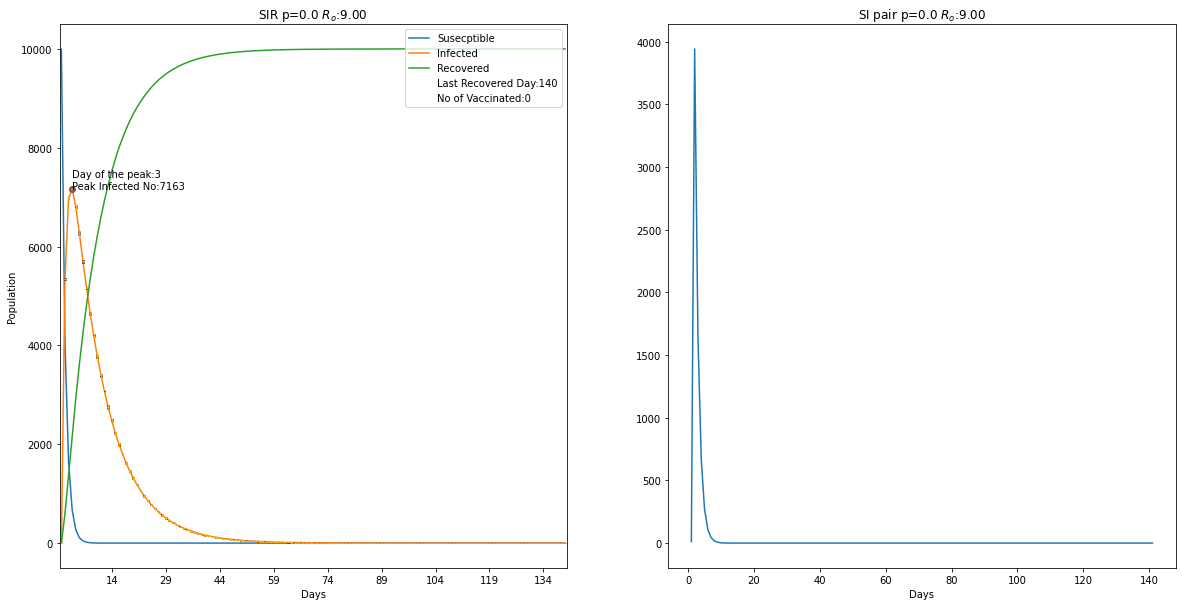

In [19]:
#Validation of the Simulation
beta=0.9
gamma=0.1
vacc_flag=1
Reproductive_No=beta/gamma

sim_replication(1,0)


C:\Users\mrudu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


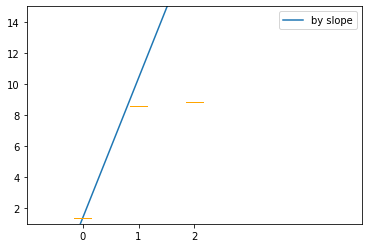

In [20]:
fig, ax = plt.subplots()

ax.axline((1, np.log(4)), slope=9, color='C0', label='by slope')
# I_df.plot(x=I_df.index,y=[1] ,ax=ax)
I_df_log=np.log(I_df)
I_df_log.head(peak_day[0]).T.boxplot(ax=ax,grid=False,showfliers=False,whis=0,color='orange',patch_artist=True,boxprops={'alpha':0.5,'facecolor':'orange'})
ax.set_xlim(0, 6)
ax.set_ylim(1, 15) 
ax.legend()

In [21]:
I_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,I_Mean
0,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4.00
1,5334,5358,5368,5369,5313,5363,5280,5334,5287,5362,...,5404,5381,5282,5309,5380,5458,5320,5370,5316,5345.24
2,7016,6972,6944,7047,6906,6984,6948,6924,6901,6943,...,6986,6963,6959,7002,7017,7017,6958,6963,6971,6978.66
3,7184,7177,7158,7225,7091,7186,7169,7168,7089,7145,...,7168,7158,7141,7177,7193,7214,7195,7150,7167,7163.24
4,6765,6871,6849,6805,6722,6858,6818,6795,6722,6824,...,6826,6792,6831,6781,6820,6820,6876,6815,6839,6807.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00


def animi(i):    
    ax.clear()
    im = ax.imshow(matrices[:,:,i])
anim = ani.FuncAnimation(fig, animi,frames=tend,  interval=1000, blit=False)
from IPython.display import HTML
HTML(anim.to_jshtml())
anim.save('save.gif',dpi=80, writer='imagemagick')



    # with pd.ExcelWriter('output.xlsx') as writer:
    writer= pd.ExcelWriter('output.xlsx', engine='openpyxl')
    sheet_names=(f'p=%d'%p)
    I_df['I_Mean'].to_excel(writer,sheet_name=sheet_names,index=False,startcol=2)
    R_df['R_Mean'].to_excel(writer,sheet_name=sheet_names,index=False,startcol=3)
    S_df['S_Mean'].to_excel(writer,sheet_name=sheet_names,index=False,startcol=1)
    SI_pair_df['SI_Mean'].to_excel(writer,sheet_name=sheet_names,index=False,startcol=4)


    # with pd.ExcelWriter('output.xlsx') as writer:
    writer= pd.ExcelWriter('output.xlsx', engine='openpyxl')
    sheet_names=(f'p=%d'%p)
    I_df['I_Mean'].to_excel(writer,sheet_name=sheet_names,index=False,startcol=2)
    R_df['R_Mean'].to_excel(writer,sheet_name=sheet_names,index=False,startcol=3)
    S_df['S_Mean'].to_excel(writer,sheet_name=sheet_names,index=False,startcol=1)
    SI_pair_df['SI_Mean'].to_excel(writer,sheet_name=sheet_names,index=False,startcol=4)
